In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import seaborn as sns

In [106]:
vacc_url = 'https://opendata.arcgis.com/datasets/f23a050f72774954a91263f77031dfa3_0.csv'
df = pd.read_csv(vacc_url, parse_dates=['ADMIN_DATE'])
df['ADMIN_DATE'] = df['ADMIN_DATE'].dt.tz_localize(None)
df.to_csv('../data/raw/vaccines.csv', index=False)

In [107]:
df = df.dropna(thresh=5).copy()

In [108]:
bad_dates = {}

for group_name, df_group in df[df['ADMIN_DATE']<'15 DEC 2020'].groupby('MVX'):
    bad_dates[group_name] = len(df_group)

df = df[df['ADMIN_DATE']>='15 DEC 2020'].copy()

In [109]:
bad_dates

{'PFR': 4}

In [110]:
df = df[df['DOSE_NUM']<2].copy()

In [111]:
df['ADMIN_DATE'] = pd.to_datetime(df['ADMIN_DATE']).dt.date

In [112]:
df.head()

,ADMIN_DATE,MVX,DOSE_NUM,VAX_SERIES_COMPLETE,REGION_NUM,BEHAVIORAL_REGION,BOROUGH_FIPS,BOROUGH_NAME,ADJ_BOROUGH_FIPS,ADJ_BOROUGH_NAME,RECIP_RESIDENT_IND,Unique_Count,DATA_DT,FID
0,2021-01-27,PFR,1,NO,4,Kenai Peninsula Region,122,Kenai Peninsula Borough,122,Kenai Peninsula Borough,1,63,2021/05/18 00:00:00+00,1
1,2021-01-27,PFR,1,NO,10,Y-K Delta Region,270,Kusilvak Census Area,158,Kusilvak Census Area,0,1,2021/05/18 00:00:00+00,2
2,2021-01-27,PFR,1,NO,10,Y-K Delta Region,270,Kusilvak Census Area,158,Kusilvak Census Area,1,180,2021/05/18 00:00:00+00,3
3,2021-01-27,PFR,1,NO,11,Southwest Region,13,Aleutians East Borough,13,Aleutians East Borough,1,1,2021/05/18 00:00:00+00,4
8,2021-01-28,MOD,1,UNK,7,Other Interior Region,290,Yukon-Koyukuk Census Area,290,Yukon-Koyukuk Census Area,1,1,2021/05/18 00:00:00+00,9


In [113]:
df_vacc = pd.pivot_table(df, values='Unique_Count', index='ADMIN_DATE', columns='MVX', aggfunc='sum')

In [114]:
df_vacc = df_vacc.fillna(0)

In [115]:
df_vacc.head()

MVX,JSN,MOD,OTH,PFR,UNK
ADMIN_DATE,,,,,
2020-12-15,0.0,1.0,0.0,127.0,0.0
2020-12-16,0.0,0.0,0.0,1179.0,0.0
2020-12-17,0.0,0.0,0.0,2303.0,0.0
2020-12-18,0.0,0.0,0.0,3108.0,0.0
2020-12-19,0.0,0.0,0.0,883.0,0.0


In [116]:
cols = df_vacc.columns
df_vacc['total'] = df_vacc[cols].sum(axis=1)

In [117]:
df_vacc.to_csv('../data/parsed/vaccines.csv', index=True)
last_date = df_vacc.index[-5]
# last_date = pd.to_datetime('26 FEB 2021')
df_vacc['cumulative_total'] = df_vacc['total'].cumsum()
total_first_dose = df_vacc['cumulative_total'][-5]
df_vacc.tail(10)

MVX,JSN,MOD,OTH,PFR,UNK,total,cumulative_total
ADMIN_DATE,,,,,,,
2021-05-10,140.0,202.0,0.0,179.0,0.0,521.0,305759.0
2021-05-11,227.0,204.0,0.0,474.0,0.0,905.0,306664.0
2021-05-12,189.0,284.0,0.0,261.0,0.0,734.0,307398.0
2021-05-13,157.0,202.0,0.0,541.0,0.0,900.0,308298.0
2021-05-14,349.0,320.0,1.0,729.0,0.0,1399.0,309697.0
2021-05-15,163.0,101.0,0.0,331.0,0.0,595.0,310292.0
2021-05-16,47.0,57.0,0.0,153.0,0.0,257.0,310549.0
2021-05-17,180.0,203.0,1.0,335.0,0.0,719.0,311268.0
2021-05-18,87.0,166.0,0.0,248.0,1.0,502.0,311770.0


In [118]:
df_vacc['JSN'].sum()

19231.0

## Build Models

In [119]:
from fbprophet import Prophet

In [120]:
m_pfr = Prophet(growth='logistic')
m_mod = Prophet(growth='logistic')
m_tot = Prophet(growth='logistic')

In [121]:
df_pfr = df_vacc[df_vacc.index<last_date].reset_index()[['ADMIN_DATE', 'PFR']]
df_pfr.columns = ['ds', 'y']
df_pfr['cap']=10E3
df_pfr['floor']=0

df_mod = df_vacc[df_vacc.index<last_date].reset_index()[['ADMIN_DATE', 'MOD']]
df_mod.columns = ['ds', 'y']
df_mod['cap']=10E3
df_mod['floor']=0

df_tot = df_vacc[df_vacc.index<last_date].reset_index()[['ADMIN_DATE', 'total']]
df_tot.columns = ['ds', 'y']
df_tot['cap']=10E3
df_tot['floor']=0

In [122]:
m_pfr.fit(df_pfr)
m_mod.fit(df_mod)
m_tot.fit(df_tot)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [123]:
future_pfr = m_pfr.make_future_dataframe(periods=60)
future_pfr['cap'] =10E3
future_pfr['floor'] = 0
future_pfr.tail()

future_mod = m_mod.make_future_dataframe(periods=60)
future_mod['cap'] =10E3
future_mod['floor'] = 0
future_mod.tail()

future_tot = m_tot.make_future_dataframe(periods=60)
future_tot['cap'] =10E3
future_tot['floor'] = 0
future_tot.tail()

,ds,cap,floor
205,2021-07-09,10000.0,0
206,2021-07-10,10000.0,0
207,2021-07-11,10000.0,0
208,2021-07-12,10000.0,0
209,2021-07-13,10000.0,0


In [124]:
forecast_pfr = m_pfr.predict(future_pfr)
forecast_pfr[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

forecast_mod = m_mod.predict(future_mod)
forecast_mod[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

forecast_tot = m_tot.predict(future_tot)
forecast_tot[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
205,2021-07-09,2997.930874,1185.785202,4884.471256
206,2021-07-10,2166.790111,386.299085,3900.535280
207,2021-07-11,952.765633,-812.817869,2766.893876
208,2021-07-12,1968.384021,71.236846,3757.357455
209,2021-07-13,2877.841395,1110.185190,4743.353121


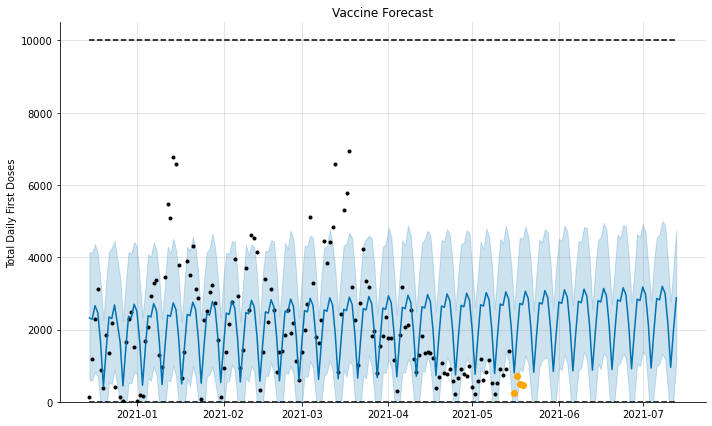

In [125]:
# check the accuracy of the forecast graphically

fig1 = m_tot.plot(forecast_tot)
plt.plot(df_vacc[last_date<df_vacc.index].index, df_vacc[last_date<df_vacc.index]['total'], color='orange', marker='o', ls='')
plt.title('Vaccine Forecast')
plt.ylabel('Total Daily First Doses')
plt.xlabel('')
plt.ylim(0,10500)
sns.despine();

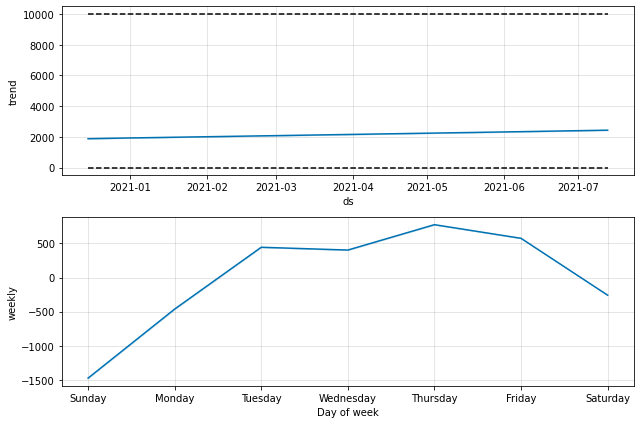

In [126]:
fig2 = m_tot.plot_components(forecast_tot)

Text(0.5, 33.0, '')

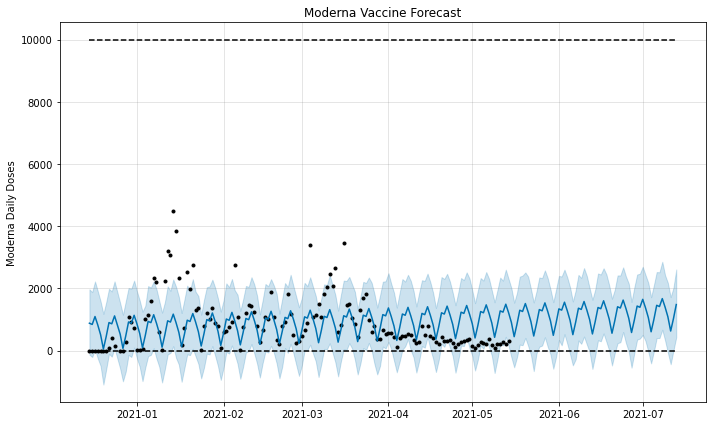

In [127]:
fig1 = m_mod.plot(forecast_mod)
plt.title('Moderna Vaccine Forecast')
plt.ylabel('Moderna Daily Doses')
plt.xlabel('')

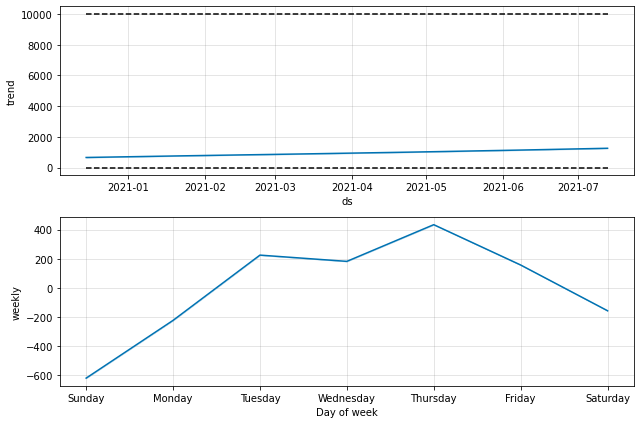

In [128]:
fig2 = m_mod.plot_components(forecast_mod)

Text(0.5, 33.0, '')

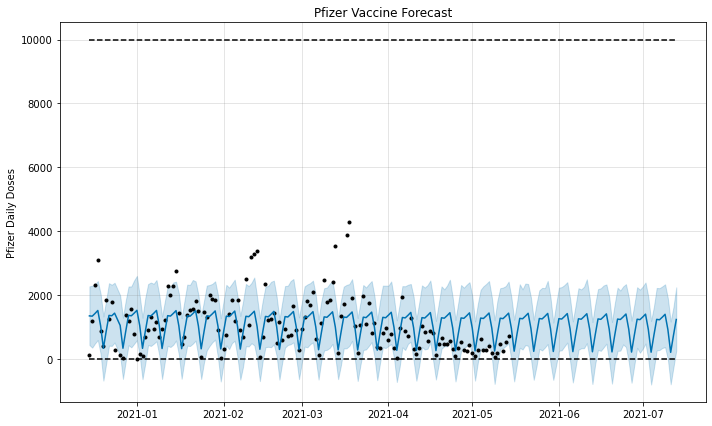

In [129]:
fig1 = m_pfr.plot(forecast_pfr)
plt.title('Pfizer Vaccine Forecast')
plt.ylabel('Pfizer Daily Doses')
plt.xlabel('')

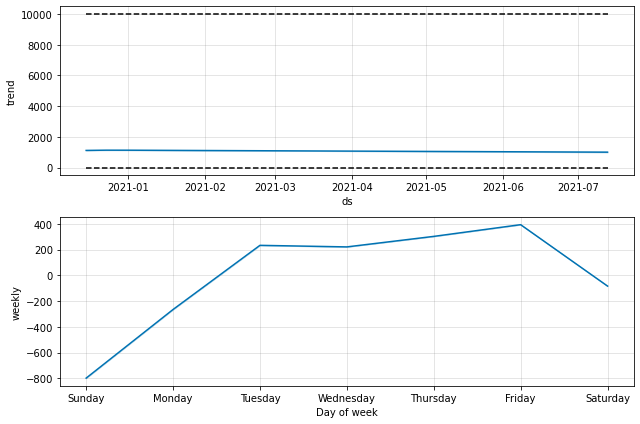

In [130]:
fig2 = m_pfr.plot_components(forecast_pfr)

## Check Cumulative First Doses

In [131]:
df_forecast = forecast_tot[forecast_tot['ds'].dt.date>last_date].copy()

In [132]:
df_forecast['yhat'] = round(df_forecast['yhat'],0)
df_forecast['cumulative_yhat'] = df_forecast['yhat'].cumsum()
df_forecast['cumulative_yhat'] = df_forecast['cumulative_yhat']+total_first_dose

In [133]:
total_ak_pop = 585E3
total_ak_pop*0.50

292500.0

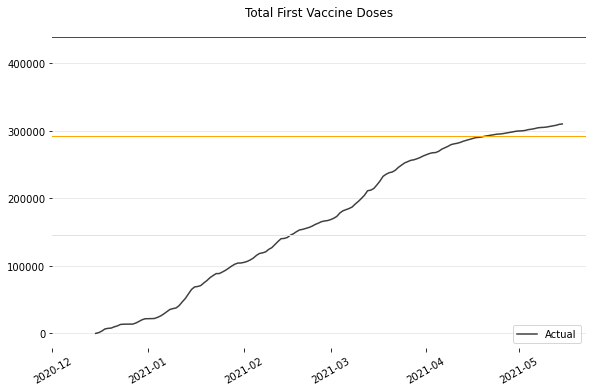

In [134]:
fig, ax = plt.subplots(figsize=(600/72,400/72))
ax.set_title('Total First Vaccine Doses')
ax.plot(df_vacc[df_vacc.index<=last_date].index, df_vacc[df_vacc.index<=last_date]['cumulative_total'], c='black', label='Actual', linestyle='-', zorder=1, alpha=.75)
# ax.plot(df_forecast['ds'], df_forecast['cumulative_yhat'], c='blue', label='Forecasted', linestyle='-', zorder=1, alpha=.75)
ax.legend()
plt.axhline(total_ak_pop*0.25, color='yellow', linewidth=1)

plt.axhline(total_ak_pop*0.50, color='orange', linewidth=1)

plt.axhline(total_ak_pop*0.75, color='green', linewidth=1)

ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.autofmt_xdate(ha='center', )

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2))

ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
ax.set_xlim(pd.Timestamp('2020-12-01'),)


fig.set_facecolor('w')

fig.tight_layout()

In [135]:
df_vacc.tail(25)

MVX,JSN,MOD,OTH,PFR,UNK,total,cumulative_total
ADMIN_DATE,,,,,,,
2021-04-25,22.0,102.0,0.0,99.0,0.0,223.0,295464.0
2021-04-26,73.0,224.0,0.0,355.0,0.0,652.0,296116.0
2021-04-27,117.0,263.0,0.0,530.0,0.0,910.0,297026.0
2021-04-28,180.0,317.0,0.0,270.0,0.0,767.0,297793.0
2021-04-29,140.0,326.0,0.0,257.0,0.0,723.0,298516.0
2021-04-30,171.0,377.0,0.0,446.0,0.0,994.0,299510.0
2021-05-01,81.0,132.0,0.0,191.0,0.0,404.0,299914.0
2021-05-02,35.0,89.0,0.0,82.0,0.0,206.0,300120.0
2021-05-03,117.0,178.0,0.0,282.0,0.0,577.0,300697.0


In [136]:
df_forecast.head(50)

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,cumulative_yhat
151,2021-05-16,2275.632685,10000.0,0,-974.206328,2562.941651,2275.620648,2275.641179,-1475.613638,-1475.613638,-1475.613638,-1475.613638,-1475.613638,-1475.613638,0.0,0.0,0.0,800.0,311092.0
152,2021-05-17,2278.299926,10000.0,0,12.886103,3586.288747,2278.263330,2278.340418,-462.785174,-462.785174,-462.785174,-462.785174,-462.785174,-462.785174,0.0,0.0,0.0,1816.0,312908.0
153,2021-05-18,2280.969370,10000.0,0,925.693443,4552.477006,2280.893996,2281.062366,443.880101,443.880101,443.880101,443.880101,443.880101,443.880101,0.0,0.0,0.0,2725.0,315633.0
154,2021-05-19,2283.641016,10000.0,0,843.228548,4493.480565,2283.519056,2283.792221,402.991079,402.991079,402.991079,402.991079,402.991079,402.991079,0.0,0.0,0.0,2687.0,318320.0
155,2021-05-20,2286.314865,10000.0,0,1270.154419,4850.996607,2286.135850,2286.533023,775.204120,775.204120,775.204120,775.204120,775.204120,775.204120,0.0,0.0,0.0,3062.0,321382.0
156,2021-05-21,2288.990916,10000.0,0,1095.667814,4591.274777,2288.743805,2289.282669,575.124924,575.124924,575.124924,575.124924,575.124924,575.124924,0.0,0.0,0.0,2864.0,324246.0
157,2021-05-22,2291.669169,10000.0,0,283.000132,3812.737407,2291.360784,2292.047156,-258.801412,-258.801412,-258.801412,-258.801412,-258.801412,-258.801412,0.0,0.0,0.0,2033.0,326279.0
158,2021-05-23,2294.349623,10000.0,0,-831.344906,2506.642910,2293.970633,2294.819208,-1475.613638,-1475.613638,-1475.613638,-1475.613638,-1475.613638,-1475.613638,0.0,0.0,0.0,819.0,327098.0
159,2021-05-24,2297.032277,10000.0,0,45.032371,3584.999928,2296.589089,2297.596817,-462.785174,-462.785174,-462.785174,-462.785174,-462.785174,-462.785174,0.0,0.0,0.0,1834.0,328932.0
160,2021-05-25,2299.717133,10000.0,0,944.746620,4489.088043,2299.192387,2300.372927,443.880101,443.880101,443.880101,443.880101,443.880101,443.880101,0.0,0.0,0.0,2744.0,331676.0


In [137]:
forecast_tot[forecast_tot['ds'].dt.date>last_date]

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
151,2021-05-16,2275.632685,10000.0,0,-974.206328,2562.941651,2275.620648,2275.641179,-1475.613638,-1475.613638,-1475.613638,-1475.613638,-1475.613638,-1475.613638,0.0,0.0,0.0,800.019048
152,2021-05-17,2278.299926,10000.0,0,12.886103,3586.288747,2278.263330,2278.340418,-462.785174,-462.785174,-462.785174,-462.785174,-462.785174,-462.785174,0.0,0.0,0.0,1815.514752
153,2021-05-18,2280.969370,10000.0,0,925.693443,4552.477006,2280.893996,2281.062366,443.880101,443.880101,443.880101,443.880101,443.880101,443.880101,0.0,0.0,0.0,2724.849470
154,2021-05-19,2283.641016,10000.0,0,843.228548,4493.480565,2283.519056,2283.792221,402.991079,402.991079,402.991079,402.991079,402.991079,402.991079,0.0,0.0,0.0,2686.632095
155,2021-05-20,2286.314865,10000.0,0,1270.154419,4850.996607,2286.135850,2286.533023,775.204120,775.204120,775.204120,775.204120,775.204120,775.204120,0.0,0.0,0.0,3061.518985
156,2021-05-21,2288.990916,10000.0,0,1095.667814,4591.274777,2288.743805,2289.282669,575.124924,575.124924,575.124924,575.124924,575.124924,575.124924,0.0,0.0,0.0,2864.115840
157,2021-05-22,2291.669169,10000.0,0,283.000132,3812.737407,2291.360784,2292.047156,-258.801412,-258.801412,-258.801412,-258.801412,-258.801412,-258.801412,0.0,0.0,0.0,2032.867757
158,2021-05-23,2294.349623,10000.0,0,-831.344906,2506.642910,2293.970633,2294.819208,-1475.613638,-1475.613638,-1475.613638,-1475.613638,-1475.613638,-1475.613638,0.0,0.0,0.0,818.735985
159,2021-05-24,2297.032277,10000.0,0,45.032371,3584.999928,2296.589089,2297.596817,-462.785174,-462.785174,-462.785174,-462.785174,-462.785174,-462.785174,0.0,0.0,0.0,1834.247103
160,2021-05-25,2299.717133,10000.0,0,944.746620,4489.088043,2299.192387,2300.372927,443.880101,443.880101,443.880101,443.880101,443.880101,443.880101,0.0,0.0,0.0,2743.597233


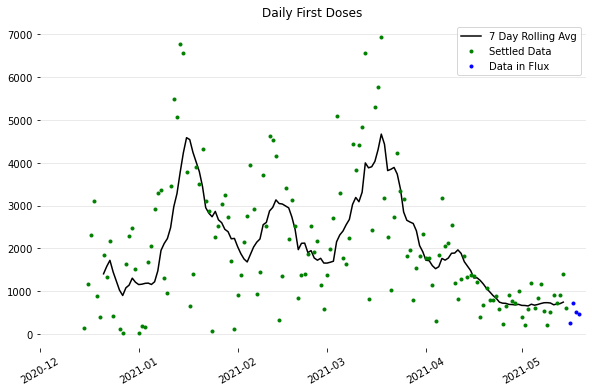

In [138]:
fig, ax = plt.subplots(figsize=(600/72,400/72))
ax.set_title('Daily First Doses')

ax.plot(df_vacc[last_date>df_vacc.index].index, df_vacc[last_date>df_vacc.index]['total'].rolling(7).mean(), 'k-', label='7 Day Rolling Avg')
ax.plot(df_vacc[last_date>=df_vacc.index].index, df_vacc[last_date>=df_vacc.index]['total'], 'g.', label='Settled Data')
ax.plot(df_vacc[last_date<df_vacc.index].index, df_vacc[last_date<df_vacc.index]['total'], 'b.', label='Data in Flux')

ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.autofmt_xdate(ha='center', )

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2))

ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)

   
# for key, value in vacc_dates.items():
#     plt.axvline(parse(key), color='k', linewidth=1)
#     plt.text(parse(key), y2*0.01, value, rotation=90, va='bottom', ha='right')
    
#     plt.axvline(parse('5 OCT 2020'), color='black')
ax.legend()

fig.set_facecolor('w')

ax.set_xlim(pd.Timestamp('1 DEC 2020'), date.today())
fig.tight_layout()